## MCMC Sampler
This notebook contains the MCMC sampler. It will sample the fiducial cosmology and the noise datavectors. Make sure to generate datavectors from chisq.ipynb first. Much of the sampling code is identitical to the code in the "LSST-Year1-tutorial" repository I forked.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib notebook

In [2]:
### Functions
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    #plt.show()
    
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [3]:
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

In [4]:
lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

In [5]:
# Code taken from the emulator notebook
#first the fiducial cosmology

configfile = 'configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = 'output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load('model/nn_emu/model')
# ======================================================

data_model.emu = emu

In [6]:
bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

In [7]:
N_MCMC        = 5000
N_WALKERS     = 120
NDIM_SAMPLING = 29

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [8]:
start_time = time.time()
with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|███████████████████████████████████████████████████████████| 5000/5000 [05:51<00:00, 14.21it/s]


<IPython.core.display.Javascript object>


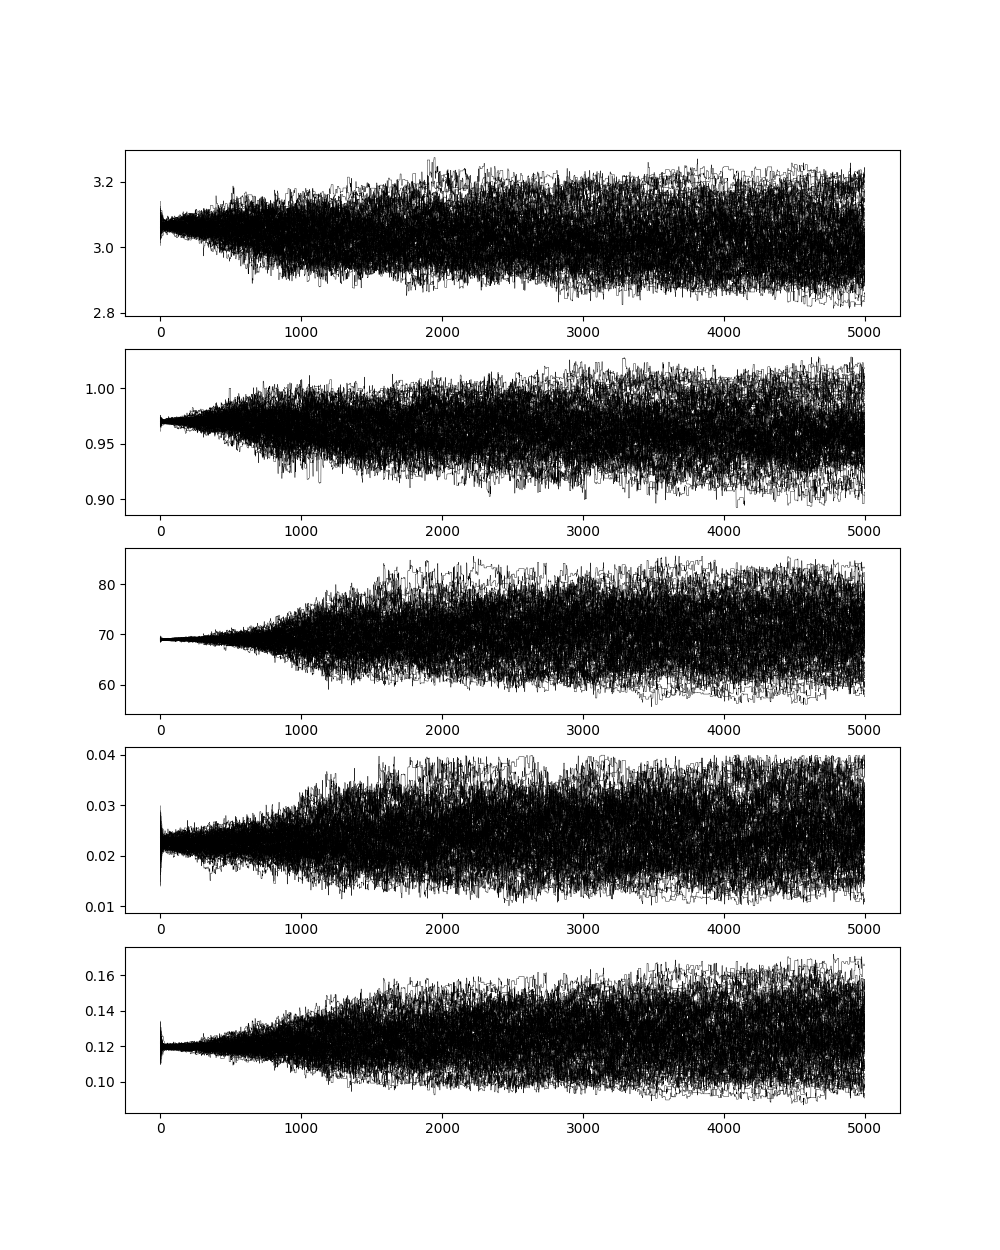

In [9]:
fig, ax = plt.subplots(5,1,figsize=(10,12.5))

for i in range(5):
    ax[i].plot(emu_sampler.chain[:,:,i].T, 'k-', lw=0.3)
    
plt.show()

In [10]:
N_BURN_IN = 3000
N_THIN    = 5

In [11]:
samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in


<IPython.core.display.Javascript object>


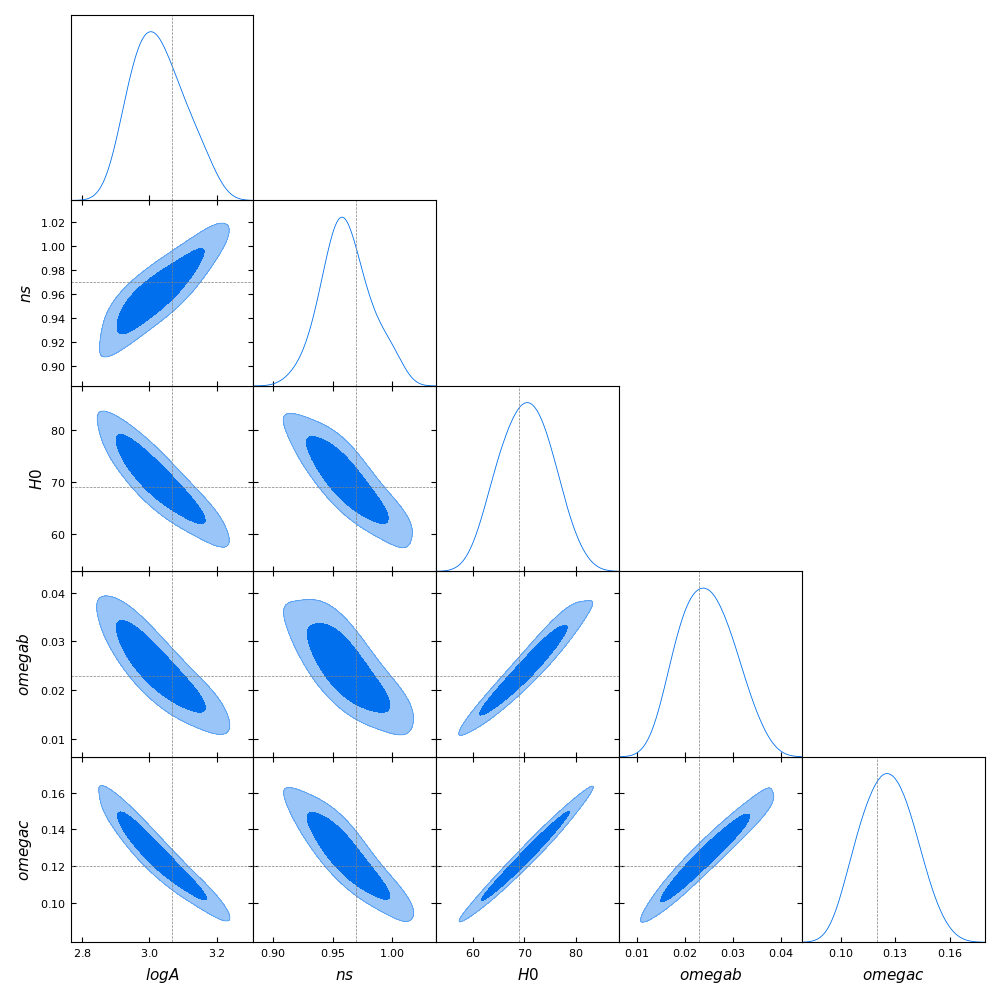

In [12]:
plot_cosmo_contours([samples], ['Fiducial scalecut'])

In [13]:
# save fiducial
d = '/home/grads/data/evan/tension_calibration/mc_data/fiducial'
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
cosmo_samples = samples[:,:5]
s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
s.saveAsText(root=d,chain_index=None,make_dirs=True)

Removed no burn in


In [14]:
noise_samples = []

# For now I will just pick 1 data vector from each confidence interval
dv_dir = '/home/grads/data/evan/tension_calibration/dvs/'
confidence_levels = [0.6827,0.9545,0.9973,1]
dvs_67 = dv_dir+'noisy_dv_0.6827.csv'
dvs_95 = dv_dir+'noisy_dv_0.9545.csv'
dvs_99 = dv_dir+'noisy_dv_0.9973.csv'
dvs_1  = dv_dir+'noisy_dv_1.csv'

dirs = [ dv_dir+'noisy_dv_'+str(cl)+'.csv' for cl in confidence_levels ]
for _d in dirs:
    dvs = np.loadtxt(_d,delimiter=',')

    randint = np.random.randint(len(dvs))
    noise_samples.append(dvs[randint])
    
print(noise_samples)

[array([ 1.08965824e-05,  6.85179475e-06,  5.92534843e-06, ...,
       -1.04500195e-05, -1.16414931e-05,  5.62264404e-06]), array([ 6.61785816e-06,  7.95730193e-06,  3.76041226e-06, ...,
       -2.75093407e-05, -1.07695791e-06,  2.29527723e-06]), array([ 1.66024365e-05,  3.96418727e-06,  5.60418721e-06, ...,
       -1.17248910e-05, -8.74201578e-06, -1.31216411e-05]), array([ 1.41608834e-05,  3.38802192e-06,  8.65198308e-06, ...,
        1.05675663e-05, -2.39476435e-06, -9.84004691e-06])]


In [15]:
i = 1
samples = []
#only if you do not want to run all dv
for data_vector in noise_samples:
    print('data vector {}/{}'.format(i,len(noise_samples)))
    i += 1
    data_model.dv_obs = data_vector
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
        samples.append(emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING)))

data vector 1/4


100%|███████████████████████████████████████████████████████████| 5000/5000 [05:54<00:00, 14.09it/s]

data vector 2/4



100%|███████████████████████████████████████████████████████████| 5000/5000 [05:52<00:00, 14.17it/s]

data vector 3/4



100%|███████████████████████████████████████████████████████████| 5000/5000 [05:56<00:00, 14.01it/s]


data vector 4/4


100%|███████████████████████████████████████████████████████████| 5000/5000 [05:55<00:00, 14.08it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<IPython.core.display.Javascript object>


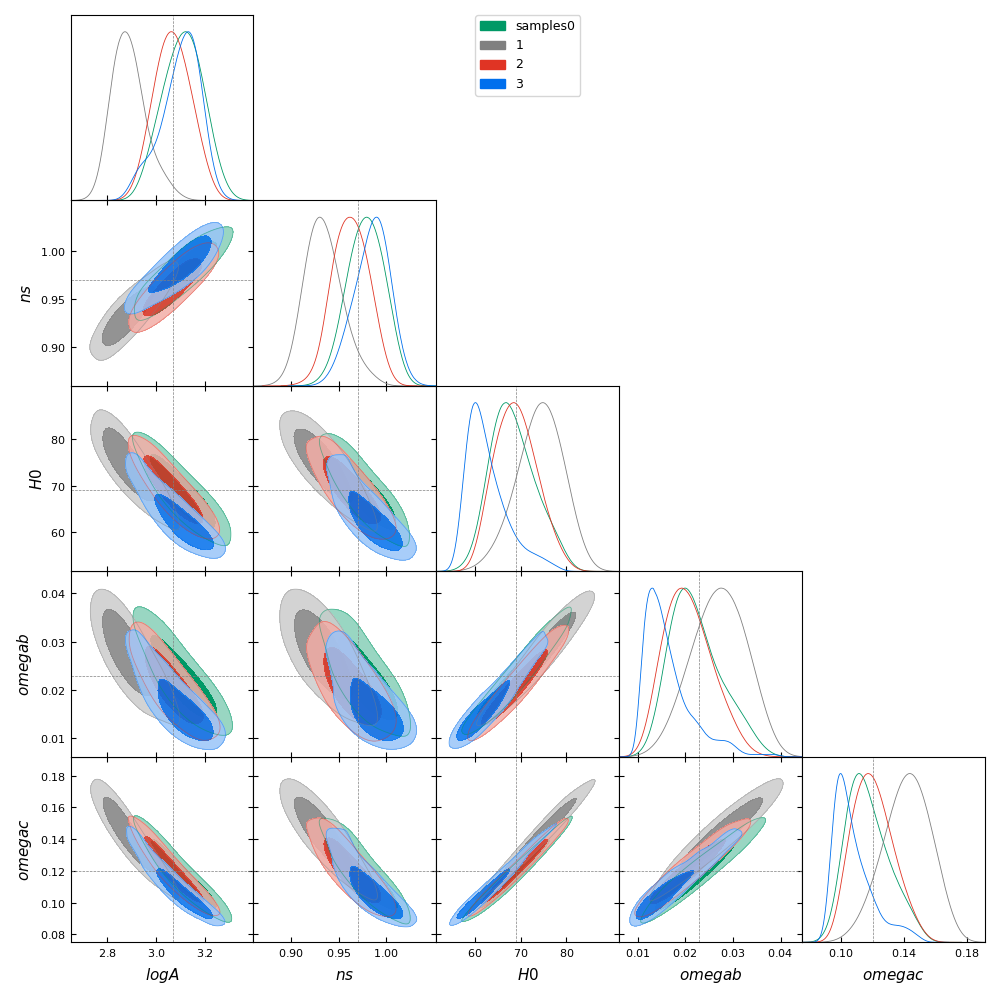

In [16]:
plot_cosmo_contours(samples,np.arange(len(samples)))

In [17]:
# write chains to files
d = '/home/grads/data/evan/tension_calibration/mc_data/noise'
i=0

names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']

for _s in samples:
    cosmo_samples = _s[:,:5]
    s = MCSamples(samples=cosmo_samples,names = names, labels=labels)
    s.saveAsText(root=d+'_'+str(confidence_levels[i]),chain_index=None,make_dirs=True)
    i += 1

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
